Jupyter Notebook script for Quantum Computing exam, written by EPFL exchange student Clara Wimmelmann 

Initiated: Christmas 2024, 
Last edited: January 14 2025

In [112]:
#!pip install qiskit qiskit_aer qiskit_ibm_runtime matplotlib pylatexenc
#!pip install qiskit-aer
#!pip install qiskit-ibm-provider


In [113]:
tok='d3fdb9e473ff3b520ed4b56941f760b6d5dbfeeee5732325146570eba24411ef1c31ef26f458a09f8d05637348004dc23b0911a44020347e5e9a2efcefca2188'

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider

# Save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', token=tok, overwrite = True)

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
)

# Import packages

In [114]:

import numpy as np
import math
from scipy.linalg import expm
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram
from qiskit.synthesis import EvolutionSynthesis
from qiskit.circuit.library import UnitaryGate, PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info.operators.symplectic import Pauli


# Make circuit 

### Implement on IBM-Q the smallest instance of the algorithm (which should require 5 qubits), for the simulation of the NESS of a single spin subject to spin relaxation and an external field

In [115]:


def create_quantum_circuit(t, h, hp):
    """
    Creates a quantum circuit implementing the steps outlined, parameterized by t, h, and hp.
    
    Parameters:
        t (int): Number of qubits in the first register (related to precision).
        h (float): Parameter for the sparse Pauli operator.
        hp (float): Additional parameter for the sparse Pauli operator.
    
    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    N = 1  # Number of spins (fixed in this example)
    first_register = QuantumRegister(t, name='q1')
    second_register = QuantumRegister(2 * N + 1, name='q2')
    classical_register = ClassicalRegister(t + 2 * N + 1, name='c')
    circuit = QuantumCircuit(first_register, second_register, classical_register)
    
    end = t + 2 * N + 1
    
    # Step 1: Initial state preparation
    circuit.h(end - 1)  # Apply Hadamard to the last qubit
    circuit.ch(end - 1, end - 2)
    circuit.cx(end - 2, end - 3)  # CNOT gates
    circuit.x(end - 1)  # Final X gate in preparation
    circuit.barrier()
    
    # Step 2: Quantum Phase Estimation (QPE) operations
    for i in range(t):
        circuit.h(i)  # Apply Hadamard to the first t qubits

    t_0 = 1 / 5  # Fixed time parameter
    M = SparsePauliOp.from_list(
        [
            ("YIX", h),
            ("YXI", -h),
            ("YIY", hp),
            ("YYI", hp),
            ("YXY", 1 / 4),
            ("YYX", 1 / 4),
            ("XXX", 1 / 4),
            ("XYY", -1 / 4),
            ("XIZ", -1 / 4),
            ("XZI", -1 / 4),
            ("XII", -1 / 2),
        ]
    )
    
    # Apply controlled exp(2^n * 2pi i M t_0) gates
    for n in range(t):
        exp_iM = expm(2 ** n * 2 * math.pi * 1j * M.to_matrix() * t_0)
        exp_iM_gate = UnitaryGate(exp_iM, label=f'exp(2^{n} * 2pi i M t_0)')
        controlled_exp_iM_gate = exp_iM_gate.control()
        circuit.append(controlled_exp_iM_gate, [first_register[n], second_register[0], second_register[1], second_register[2]])
    
    circuit.barrier()
    
    # Step 3: Add inverse Quantum Fourier Transform (QFT)
    def qft_dagger(circ, n):
        # Apply gates in reverse order for the QFT dagger
        for j in reversed(range(n)):
            circ.h(j)
            for m in range(j):
                circ.cp(-math.pi / float(2 ** (j - m)), m, j)
        # Apply swaps to reverse the order of the qubits
        for qubit in range(n // 2):
            circ.swap(qubit, n - qubit - 1)

    qft_dagger(circuit, t)
    circuit.barrier()
    
    # Step 4: Add measurement
    circuit.measure(range(t), range(t))  # Measure the first t qubits
    
    return circuit




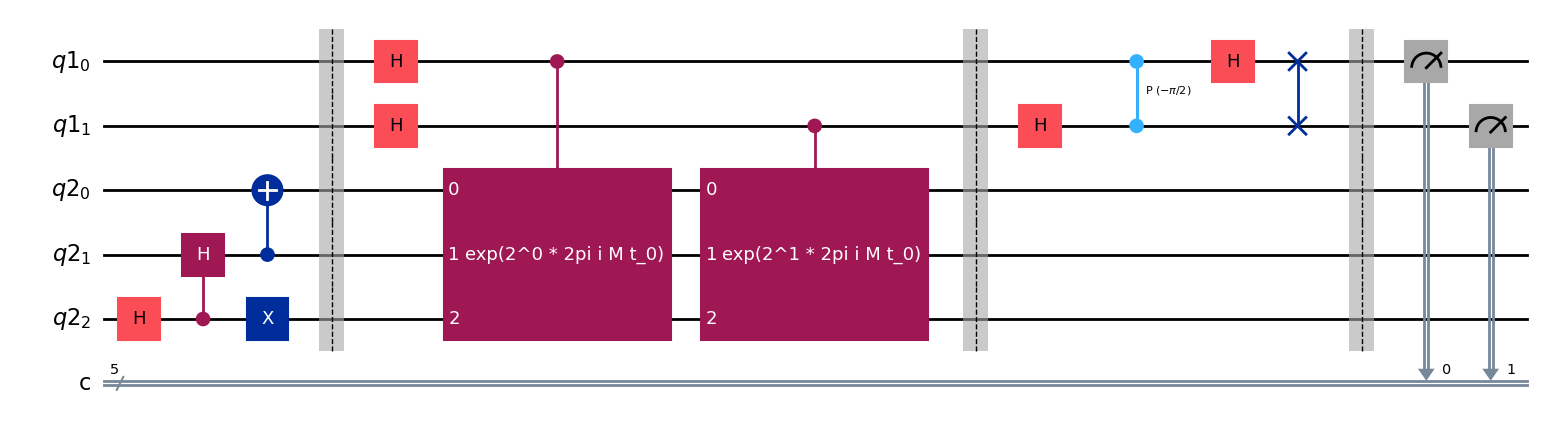

In [116]:
t = 2
h = 1.0
hp = 0

circuit = create_quantum_circuit(t, h, hp)
circuit.draw('mpl')


### Study the M matrix 

In [117]:

#Pauli matrices
I = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
h = 1.0
hp = 0
t_0 = 1/5 

#defining M
element1 = 0.5 * np.kron(sigma_x + 1j*sigma_y, np.kron(sigma_x - 1j*sigma_y, sigma_x - 1j*sigma_y))
element2 = 0.5 * np.kron(sigma_x - 1j*sigma_y, np.kron(sigma_x + 1j*sigma_y, sigma_x + 1j*sigma_y))
element3 = -0.5 * np.kron(sigma_x, np.kron(I, 2*I + 2*sigma_z))
element4 = -0.5 * np.kron(sigma_x, np.kron(2*I + 2*sigma_z, I))
element5 = np.kron(sigma_y, np.kron(I, h*sigma_x + hp*sigma_y))
element6 = -np.kron(sigma_y, np.kron(h*sigma_x - hp*sigma_y, I))
M1 = element1 + element2 + element3 + element4 + element5 + element6


#M_dagger = np.conjugate(M.T)
M1_dagger = np.conjugate(M1.T)
#is_hermitian = np.allclose(M, M_dagger)
is_hermitian1 = np.allclose(M1, M1_dagger)
is_unitary1=np.allclose(np.dot(M1, M1_dagger),np.eye(8))

#print("M:")
#print(M)
#print("\nM_dagger:")
#print(M_dagger)
#print("\nIs M Hermitian?", is_hermitian)

print("M1:")
print(M1)
print("\nM1_dagger:")
print(M1_dagger)
print("M1*\nM1_dagger:")
print(np.allclose(M1, M1_dagger))
print("\nIs M1 Hermitian?", is_hermitian1)

print(np.dot(M1, M1_dagger))
print("\nIs M1 unitary?", is_unitary1)


M1:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -4.+0.j  0.-1.j  0.+1.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j -2.+0.j  0.+0.j  0.+1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j -2.+0.j  0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  4.+0.j  0.+1.j  0.-1.j  0.+0.j]
 [-4.+0.j  0.+1.j  0.-1.j  4.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j -2.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.-1.j  0.+0.j -2.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]]

M1_dagger:
[[ 0.-0.j  0.-0.j  0.-0.j  0.-0.j -4.-0.j  0.-1.j  0.+1.j  0.-0.j]
 [ 0.-0.j  0.-0.j  0.-0.j  0.-0.j  0.-1.j -2.-0.j  0.-0.j  0.+1.j]
 [ 0.-0.j  0.-0.j  0.-0.j  0.-0.j  0.+1.j  0.-0.j -2.-0.j  0.-1.j]
 [ 0.-0.j  0.-0.j  0.-0.j  0.-0.j  4.-0.j  0.+1.j  0.-1.j  0.-0.j]
 [-4.-0.j  0.+1.j  0.-1.j  4.-0.j  0.-0.j  0.-0.j  0.-0.j  0.-0.j]
 [ 0.+1.j -2.-0.j  0.-0.j  0.-1.j  0.-0.j  0.-0.j  0.-0.j  0.-0.j]
 [ 0.-1.j  0.-0.j -2.-0.j  0.+1.j  0.-0.j  0.

# Estimate simple observables 

### Test the algorithm by estimating some simple observables, with the method presented in the last part of the manuscript. Compare with the exact result computed numerically.

In [118]:
#import circuit simulator 

from qiskit_aer import QasmSimulator, StatevectorSimulator
from qiskit_aer.noise import NoiseModel 
from qiskit_ibm_runtime import QiskitRuntimeService

service.backends(simulator=False)

backend = service.backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

statevector_simulator = StatevectorSimulator()
qasm_simulator        = QasmSimulator()
noisy_qasm_simulator  = QasmSimulator(noise_model=noise_model)



NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['id', 'reset', 'measure', 'sx', 'x', 'ecr']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

### Z average expectation value proceedure

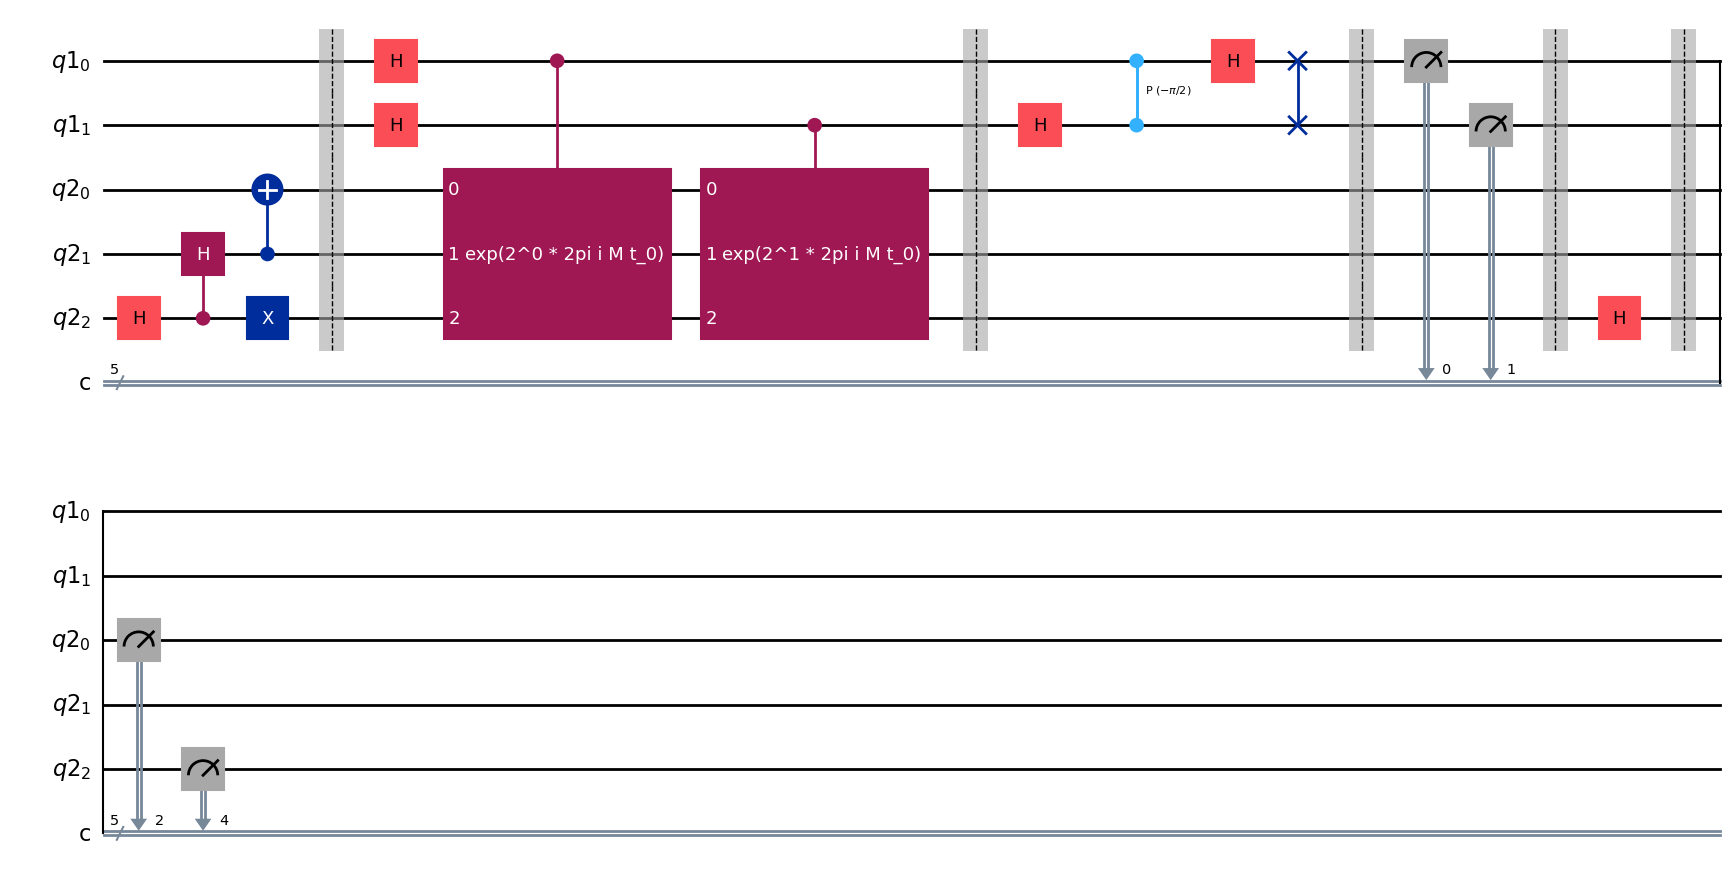

In [119]:
qcz=circuit.copy()

qcz.barrier()
#In the case of z measurement, given eq.15 in the article, the formalism says we have to 'translate' our algorithm output state in the following to measure on the eigenstate 
qcz.h(4)
qcz.barrier()
# Measure the second register (target qubits)
#qcz.measure([2, 3, 4], [2, 3, 4])
qcz.measure([2, 4], [2, 4]) #identity measures on the middle qubits. As eigenvalue/observable of identity is always 1, this corresponds to not measuring.
qcz.draw('mpl')

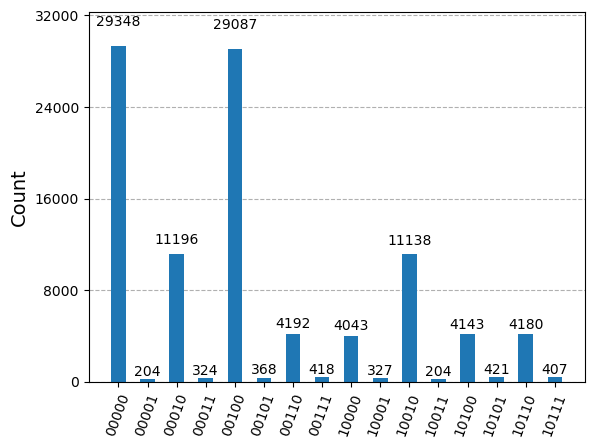

In [120]:

qczt=transpile(qcz, backend=qasm_simulator) #remember to transpile!
shots=10000
resultsz = qasm_simulator.run(qczt, shots=100000).result()
countsz=resultsz.get_counts()
plot_histogram(countsz)

In [121]:
def process_counts(counts, t):
    """
    Process measurement counts from a quantum circuit to filter, reverse, and compute expectation values.
    
    Parameters:
        counts (dict): A dictionary of bitstring outcomes and their respective counts.
        t (int): The length of the first register.
    
    Returns:
        dict: Filtered and reversed counts where the first register is "0"*t.
        float: Expectation value <Ô> computed based on the filtered counts.
    """
    # Step 1: Filter and reverse counts
    zero_pattern = "0" * t  # Define the pattern to filter the first register
    filtered_counts = {}
    for bitstring, count in counts.items():
        # Split the string: first t bits -> first register, remaining bits -> second register
        first_register = bitstring[:t]
        second_register = bitstring[t:]
        
        # Only consider cases where the first register matches "0"*t
        if first_register == zero_pattern:
            # Reverse the second register string to match the qubit numbering in the circuit
            reversed_second_register = second_register[::-1]
            
            # Accumulate counts for the reversed second register
            if reversed_second_register in filtered_counts:
                filtered_counts[reversed_second_register] += count
            else:
                filtered_counts[reversed_second_register] = count

    # Step 2: Compute <Ô> for qubits in the second register using the filtered counts
    def map_bits(bit):
        # Map '0' to 1 and '1' to -1
        return 1 if bit == '0' else -1

    mapped_values = []
    for outcome, count in filtered_counts.items():
        bit1 = outcome[0]  # First qubit in the reversed second register
        bit2 = outcome[2]  # Third qubit in the reversed second register 
        
        # Map the bits to 1 or -1 and calculate their product
        mapped_bit1 = map_bits(bit1)
        mapped_bit2 = map_bits(bit2)
        map_value = mapped_bit1 * mapped_bit2
        mapped_values.append(map_value * count)

    # Calculate the expectation value
    total_shots = sum(filtered_counts.values())
    expectation_value = sum(mapped_values)/total_shots

    return filtered_counts, expectation_value


In [122]:
filtered_counts, expectation_value=process_counts(countsz,2)
print("Average <Z>:", expectation_value)

Average <Z>: 0.1001237739063311


### Y average expectation value proceedure

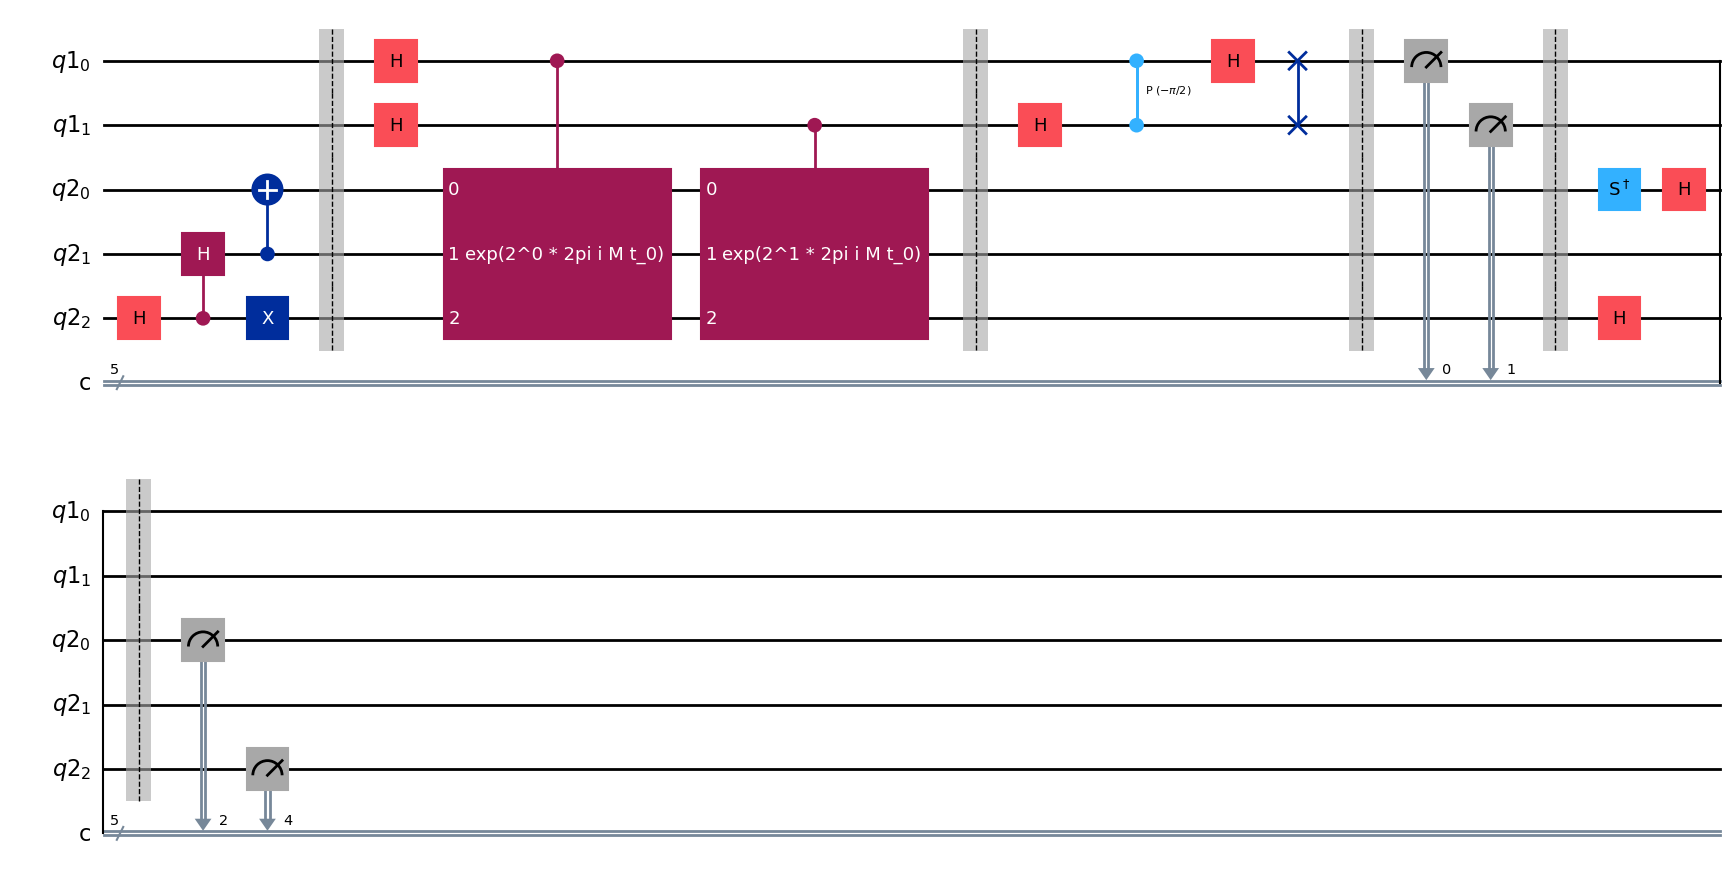

In [124]:

qcy=circuit.copy()
qcy.barrier()
qcy.h(4)
qcy.sdg(t)  # Apply S dagger to qubit t+1 so t in python indexing
qcy.h(t)    # Apply Hadamard to qubit t+1
qcy.barrier()
#qcy.measure([2, 3, 4], [2, 3, 4])  # Measure qubits 2, 3, 4 into classical bits 2, 3, 4, # Measure the second register (target qubits)
qcy.measure([2, 4], [2, 4]) 
qcy.draw('mpl')

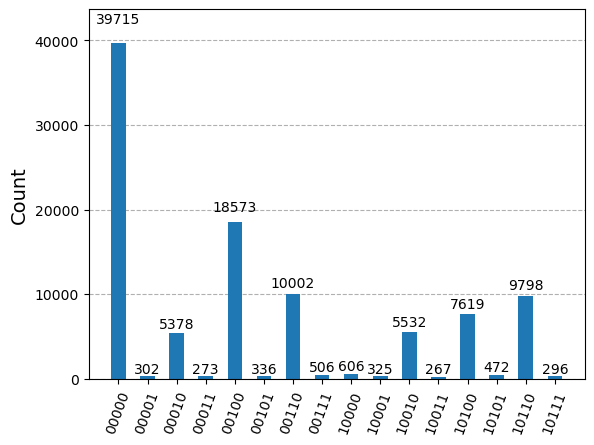

In [125]:

qcyt=transpile(qcy, backend=qasm_simulator)
resultsy = qasm_simulator.run(qcyt, shots=100000).result()
countsy = resultsy.get_counts()
plot_histogram(countsy)


In [126]:
filtered_counts, expectation_value=process_counts(countsy,2)
print("Average <Y>:", expectation_value)

Average <Y>: 0.22354664713324898


### old method of filtering and measuring observables from counts:

In [127]:


def compute_expectations(counts, t, qubits_of_interest=[2, 3, 4]):
    """
    Processes the bitstring counts, filters the results based on the first register being "00",
    and computes the expectation value for the specified qubits in the second register.

    Args:
    - counts (dict): A dictionary containing the bitstring counts (e.g., from a Qiskit simulation).
    - t (int): The number of bits in the first register (for the filter condition).
    - qubits_of_interest (list, optional): The qubits in the second register for which to compute the expectation. Default is [2, 3, 4].

    Returns:
    - average_expectation (float): The average expectation value for the specified qubits.
    - expectation_values (list): The individual expectation values for each qubit of interest.
    """
    # Initialize the filtered counts
    filtered_counts = {}
    
    # Process the results to filter out bitstrings with the first register as "00"
    for bitstring, count in counts.items():
        first_register_bits = bitstring[:t]   # Extract the leftmost t bits (first register)
        second_register_bits = bitstring[t:]  # Extract the remaining bits (second register)
        
        # Only consider cases where the first register is "00"
        if first_register_bits == "0" * t:
            # Reverse the second register string to match the qubit numbering
            reversed_second_register = second_register_bits[::-1]
            
            # Accumulate counts for the reversed second register
            if reversed_second_register in filtered_counts:
                filtered_counts[reversed_second_register] += count
            else:
                filtered_counts[reversed_second_register] = count

    # Compute expectation values for each qubit of interest
    expectation_values = []
    total_shots = sum(filtered_counts.values())  # Total shots after filtering

    # Check the number of qubits in the second register to ensure the indices are valid
    second_register_length = len(next(iter(filtered_counts.keys())))  # Get the length of the second register bitstring

    for i in qubits_of_interest:
        # Check if the qubit index is within the length of the second register
        if i >= second_register_length:
            print(f"Warning: Index {i} is out of range for the second register (max index: {second_register_length - 1})")
            continue

        # Calculate probabilities of measuring '0' and '1' for this qubit
        prob_0 = sum(val for key, val in filtered_counts.items() if key[::-1][i] == '0') / total_shots
        prob_1 = sum(val for key, val in filtered_counts.items() if key[::-1][i] == '1') / total_shots
        
        # Compute the expectation <Z> = P(0) - P(1)
        expectation_value = prob_0 - prob_1
        expectation_values.append(expectation_value)

    # Average expectation value over the qubits of interest
    average_expectation = sum(expectation_values) / len(expectation_values) if expectation_values else 0

    return average_expectation, expectation_values



## Try to make the circuits with higher t in order to get more stable results

In [128]:
N=1
t = 6
h = 1.0
hp = 0

circuitt = create_quantum_circuit(t, h, hp)
#circuit.draw('mpl')

qctz=circuitt.copy()
qctz.barrier()
#z measurement
qctz.h(t+2*N)
qctz.barrier()
# Measure the second register (target qubits)
qctz.measure([t+2*N-2,t+2*N-1,t+2*N], [t+2*N-2,t+2*N-1,t+2*N]) 
qctzt=transpile(qctz, backend=qasm_simulator)
shots=10000
resultstz = qasm_simulator.run(qctzt, shots=100000).result()
countstz=resultstz.get_counts()
plot_histogram(countstz)
filtered_countsz, expectation_valuez=process_counts(countstz,t)
print("Average <Z>:", expectation_valuez)

qcty=circuitt.copy()
qcty.barrier()
qcty.h(t+2*N)
qcty.sdg(t+2*N-2)  
qcty.h(t+2*N-2)    
qcty.barrier()
qcty.measure([t+2*N-2,t+2*N-1,t+2*N], [t+2*N-2,t+2*N-1,t+2*N]) 
qctyt=transpile(qcty, backend=qasm_simulator)
resultsty = qasm_simulator.run(qctyt, shots=100000).result()
countsty = resultsty.get_counts()
plot_histogram(countsty)
filtered_countsy, expectation_valuey=process_counts(countsty,t)
print("Average <Y>:", expectation_valuey)


average_expectation_old_z, expectation_values_old_z=compute_expectations(countstz, t, qubits_of_interest=[0, 1, 2])
print("Average <Z>:", average_expectation_old_z)

average_expectation_old_y, expectation_values_old_y=compute_expectations(countsty, t, qubits_of_interest=[0, 1, 2])
print("Average <Y>:", average_expectation_old_y)



Average <Z>: 0.9991875923190546
Average <Y>: 0.9997777901227709
Average <Z>: 0.9991875923190546
Average <Y>: 0.9998148251023092


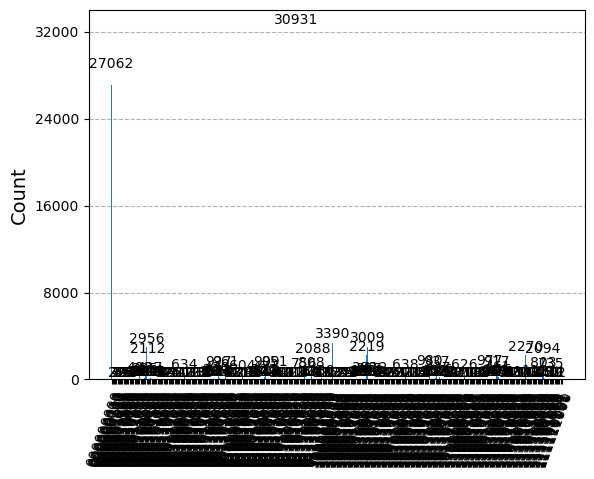

In [129]:
plot_histogram(countstz)

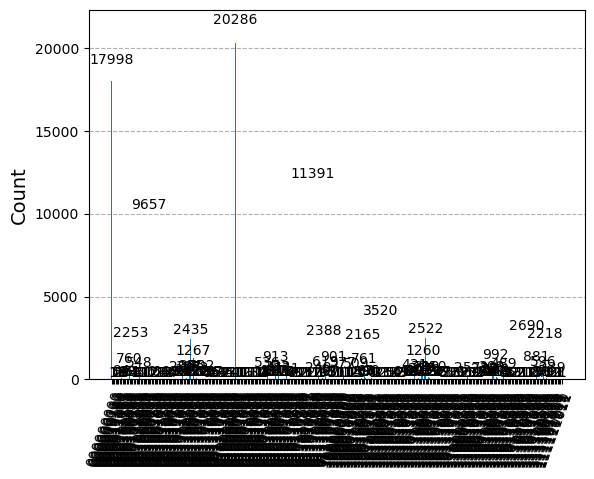

In [130]:
plot_histogram(countsty)

In [131]:
#qctz.draw('mpl')

In [132]:
#qcty.draw('mpl')

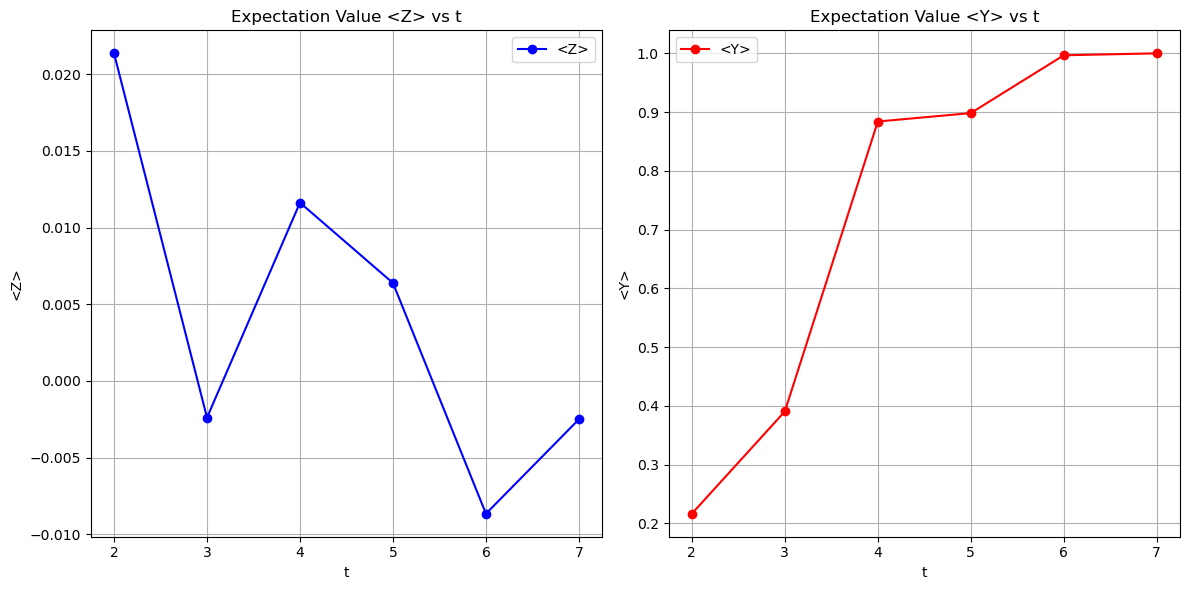

In [133]:
import matplotlib.pyplot as plt

# Initialize lists to store the results
z_expectations = []
y_expectations = []

# Loop over t from 2 to 10
for t in range(2, 8):
    # Step 1: Create the quantum circuit
    h = 1.0
    hp = 0
    circuitt = create_quantum_circuit(t, h, hp)
    
    # Step 2: Compute Z expectation
    qctz = circuitt.copy()
    qctz.barrier()
    qctz.h(2)
    qctz.barrier()
    qctz.measure([2, 4], [2, 4]) 
    qctzt = transpile(qctz, backend=qasm_simulator)
    resultstz = qasm_simulator.run(qctzt, shots=20000).result()
    countstz = resultstz.get_counts()
    # Process counts for Z observable
    filtered_countsz, expectation_valuez = process_counts(countstz, t)
    z_expectations.append(expectation_valuez)
    
    # Step 3: Compute Y expectation
    qcty = circuitt.copy()
    qcty.barrier()
    qcty.h(4)
    qcty.sdg(t)  
    qcty.h(t)
    qcty.barrier()
    qcty.measure([2, 4], [2, 4])
    qctyt = transpile(qcty, backend=qasm_simulator)
    resultsty = qasm_simulator.run(qctyt, shots=20000).result()
    countsty = resultsty.get_counts()
    # Process counts for Y observable
    filtered_countsy, expectation_valuey = process_counts(countsty, t)
    y_expectations.append(expectation_valuey)

# Step 4: Plot the results

# Plot Z expectations vs t
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 8), z_expectations, marker='o', linestyle='-', color='b', label='<Z>')
plt.title('Expectation Value <Z> vs t')
plt.xlabel('t')
plt.ylabel('<Z>')
plt.grid(True)
plt.legend()

# Plot Y expectations vs t
plt.subplot(1, 2, 2)
plt.plot(range(2, 8), y_expectations, marker='o', linestyle='-', color='r', label='<Y>')
plt.title('Expectation Value <Y> vs t')
plt.xlabel('t')
plt.ylabel('<Y>')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Exact numerically computed results (not using qiskit)

In [147]:
import numpy as np
from scipy.linalg import solve, kron, null_space

# just to remember again, this is how the paulis are saved:
I = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_plus = np.array([[0, 1], [0, 0]])  # Raising operator
sigma_minus = np.array([[0, 0], [1, 0]])  # Lowering operator

# System parameters
h = 1.0  # Magnetic field in x-direction
h_prime = 0  # Magnetic field in y-direction
H = h * sigma_x + h_prime * sigma_y # Hamiltonian
H_T = h * sigma_x - h_prime * sigma_y 

#the hamiltonian, hermitioan part of the Liouvillian:
L_H = -1j * (np.kron(I, H) - np.kron(H_T, I))
#the dissipator term in the Liouvillian :
D = -0.5 * ( np.kron(I, sigma_plus @ sigma_minus) 
                     + np.kron(sigma_plus @ sigma_minus, I) 
                     - 2 * np.kron(sigma_minus, sigma_minus))

#The Liouvillian:
L = L_H + D
print(L)

# Solving for the steady-state: L * rho = 0 using null_space pyhton built-in function
# = because The Liouvillian matrix L is expected/assumed to have a zero eigenvalue, whose corresponding eigenvector gives the steady state.
kernel = null_space(L)  # Findind the null space of L
NESS_vec = kernel[:, 0]  # Extracting the first (and only) eigenvector corresponding to the zero eigenvalue
# Reshaping the steady-state vector into a density matrix (dim 2x2)
NESS = NESS_vec.reshape(2, 2)
# Normalizing the steady-state density matrix with trace such that Tr(rho) = 1
NESS /= np.trace(NESS)  

print("Steady-state density matrix:")
print(NESS)

#below: check for safety that the found NESS is in fact in the null space of the Liouvillian L
residual = L @ NESS_vec  
norm_residual = np.linalg.norm(residual)  # Computing norm of the residual

print("check")
print("Residual (L @ NESS_vec):\n", residual)
print("Norm of residual (should approx. 0):", norm_residual)

#also for fun, checking if it hold that the jump operator are real-valued in the computational basis:
A = sigma_minus
A_dagger = A.T  # which is the same as sigma_plus
assert np.allclose(A.conj(), A), "A is not real-valued!"  # checking A^* = A


[[-1. +0.j  0. -1.j  0. +1.j  0. +0.j]
 [ 0. -1.j -0.5+0.j  0. +0.j  0. +1.j]
 [ 0. +1.j  0. +0.j -0.5+0.j  0. -1.j]
 [ 1. +0.j  0. +1.j  0. -1.j  0. +0.j]]
Steady-state density matrix:
[[ 4.44444444e-01-0.j         -9.17475972e-17+0.22222222j]
 [-3.23815049e-17-0.22222222j  5.55555556e-01-0.j        ]]
check
Residual (L @ NESS_vec):
 [ 1.38777878e-16+5.93660923e-17j  4.58737986e-17+1.11022302e-16j
  1.61907524e-17-1.11022302e-16j -1.38777878e-16-5.93660923e-17j]
Norm of residual (should approx. 0): 2.694173599912926e-16


Computing operator expectation from numerically exact NESS

In [135]:

# Vectorizing NESS as coloumn vector
NESS_vec = NESS.reshape(-1)

# Constructing operator O = I ⊗ Y
O = np.kron(I, sigma_z) 
# Computing ⟨I|
I_vec = np.eye(2).reshape(1, -1)  # Vectorized identity as a row vector
print(I_vec)
# Compute Tr(O@NESS)=⟨I|O|NESS⟩=⟨NESS|O|I⟩ i.e. eq.14 in article i.e. <Ô> as it is assumed Tr(NESS)~1 st. <Ô>=Tr(O@NESS)/Tr(NESS)
n_resultz = I_vec @ O @ NESS_vec            #n for numerical 

print(f"Tr(Z * NESS) = {n_resultz[0]}")

[[1. 0. 0. 1.]]
Tr(Z * NESS) = (-0.11111111111111127+0j)


In [146]:

# all the same steps applied for other observbles. can reuse some of them, but still need the to Construct observable: 
# O = I ⊗ Y
O = np.kron(I, sigma_y) 

# Computing Tr(O@NESS)=⟨I|O|NESS⟩=⟨NESS|O|I⟩ (assuming denominator Tr(NESS)~1) 
n_resulty = I_vec @ O @ NESS_vec

print(f"Tr(Y * NESS) = {n_resulty[0]}")

Tr(Y * NESS) = (0.44444444444444453+5.936609228898408e-17j)


## Compare the two methods (numerical and qiskit circuit estimate)

In [138]:
#compute difference, variance on circuit estimate

In [ ]:
#didn't have time and creativity enough

# QASM simulator including noise 

In [139]:

from qiskit_aer import QasmSimulator, StatevectorSimulator
from qiskit_aer.noise import NoiseModel 
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='d3fdb9e473ff3b520ed4b56941f760b6d5dbfeeee5732325146570eba24411ef1c31ef26f458a09f8d05637348004dc23b0911a44020347e5e9a2efcefca2188',overwrite = True)

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    
)

#now I replace the simulator with a noisy one
service.backends(simulator=False)
backend = service.backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)
qasm_simulator        = QasmSimulator()
noisy_qasm_simulator  = QasmSimulator(noise_model=noise_model)


NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['id', 'reset', 'measure', 'sx', 'x', 'ecr']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [140]:
import matplotlib.pyplot as plt

# Initialize lists to store the results
z_n_expectations = []

# Loop over t from 2 to 7
for t in range(2, 8):
    # Step 1: Create the quantum circuit
    h = 1.0
    hp = 0
    circuitt = create_quantum_circuit(t, h, hp)
    qct_n_z = circuitt.copy()
    qct_n_z.barrier()
    qct_n_z.h(2)
    qct_n_z.barrier()
    qct_n_z.measure([2, 4], [2, 4]) 
    
    # Compute Z expectation, reusing circuit for z-observale measuring 
    qct_n_zt = transpile(qct_n_z, backend=qasm_simulator) #n for noisy
    results_n_z = qasm_simulator.run(qct_n_zt, shots=10000).result()
    counts_n_z = results_n_z.get_counts()
    # Process counts for Z observable
    filtered_counts_n_z, expectation_value_n_z = process_counts(counts_n_z, t)
    z_n_expectations.append(expectation_value_n_z )
    



/Users/clarawimmelmann/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/clarawimmelmann/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


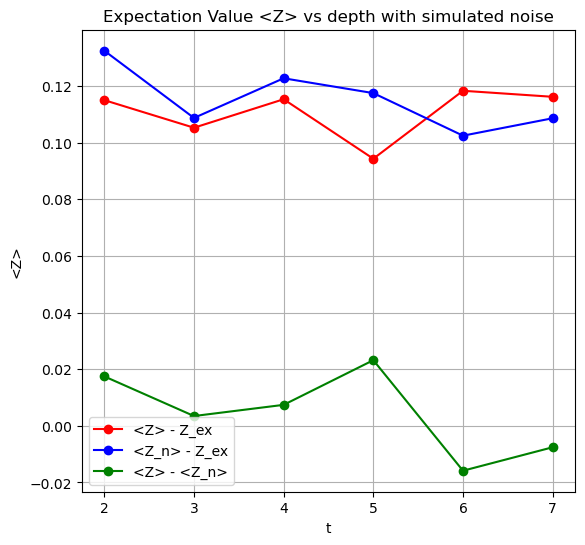

In [141]:
# Plot the results
import numpy as np

z_expectations = np.array(z_expectations)
z_n_expectations = np.array(z_n_expectations)

diff = z_expectations - z_n_expectations


# Plot Z expectations vs t
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 8), z_n_expectations-n_resultz, marker='o', linestyle='-', color='r', label='<Z> - Z_ex')
plt.plot(range(2, 8), z_expectations-n_resultz, marker='o', linestyle='-', color='b', label='<Z_n> - Z_ex')
plt.plot(range(2, 8), diff, marker='o', linestyle='-', color='g', label='<Z> - <Z_n>')
plt.title('Expectation Value <Z> vs depth with simulated noise')
plt.xlabel('t')
plt.ylabel('<Z>')
plt.grid(True)
plt.legend()

plt.show()

In [142]:

print((z_n_expectations[0]-n_resultz)/n_resultz,(z_expectations[0]-n_resultz)/n_resultz,(z_n_expectations[0]-z_expectations[0])/z_expectations[0])

[-1.03508446-0.j] [-1.19217082-0.j] -0.8174308520512346


### study how rapidly the quality of the solution deteriorates as a function of the circuit depth.

In [143]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix
from qiskit_aer import AerSimulator
from scipy.linalg import expm

# Define the function to construct the circuit as a function of t
def construct_circuit(t, N=1, h=1.0, hp=0, t_0=1/5):
    # Create registers
    first_register = QuantumRegister(t, name='q1')  # First register
    second_register = QuantumRegister(2 * N + 1, name='q2')  # Second register
    classical_register = ClassicalRegister(t + 2 * N + 1, name='c')  # Classical register

    # Create the quantum circuit (renamed to circuit2)
    circuit2 = QuantumCircuit(first_register, second_register, classical_register)

    # Step 1: Initial state preparation
    circuit2.h(range(t))  # Apply Hadamard gates to all qubits in the first register
    circuit2.ch(second_register[0], second_register[1])  # Controlled-Hadamard
    circuit2.cx(second_register[1], second_register[2])  # CNOT
    circuit2.x(second_register[0])  # Final X gate in preparation
    circuit2.barrier()

    # Step 2: Quantum Phase Estimation (QPE) operations
    M = SparsePauliOp.from_list([
        ("YIX", h),
        ("YXI", -h),
        ("YIY", hp),
        ("YYI", hp),
        ("YXY", 1 / 4),
        ("YYX", 1 / 4),
        ("XXX", 1 / 4),
        ("XYY", -1 / 4),
        ("XIZ", -1 / 4),
        ("XZI", -1 / 4),
        ("XII", -1 / 2),
    ])
    
    # Apply controlled exp(2^n * 2pi i M t_0) gates
    for n in range(t):
        controlled_exp_iM_gate = PauliEvolutionGate(M, time=2**n * 2 * np.pi * t_0, label=f'exp(2^{n} * 2pi i M t_0)').control()
        circuit2.append(controlled_exp_iM_gate, [first_register[t - n - 1]] + [second_register[i] for i in range(3)])
    
    circuit2.barrier()

    # Step 3: Add inverse Quantum Fourier Transform (QFT)
    def qft_dagger(circ, num_qubits):
        for qubit in range(num_qubits // 2):
            circ.swap(qubit, num_qubits - qubit - 1)
        for j in range(num_qubits):
            for m in range(j):
                circ.cp(-np.pi / (2 ** (j - m)), m, j)
            circ.h(j)
    qft_dagger(circuit2, t)
    circuit2.barrier()

    # Step 4: Add measurement for the first register (only for final circuit, not for statevector simulation)
    #circuit2.measure(range(t), range(t))

    return circuit2



In [144]:
# Fidelity calculation as a function of t
def calculate_fidelity(t_values):
    fidelities = []
    depths = []
    simulator = AerSimulator(noise_model=noise_model)

    for t in t_values:
        # Construct the circuit
        circuit2=construct_circuit(t, N=1, h=1.0, hp=0, t_0=1/5)

        # Simulate the ideal statevector
        transpiled_circuit = transpile(circuit2, simulator)
        result2 = simulator.run(transpiled_circuit, save_statevector=True).result()

        # Extract the ideal statevector
        ideal_statevector = result2.get_statevector()

        # Simulate the noisy circuit and save the statevector
        transpiled_circuit = transpile(circuit2, simulator)
        result2n = simulator.run(transpiled_circuit, save_statevector=True).result()

        # Extract the final statevector from the noisy simulation
        noisy_statevector = result2n.get_statevector()

        # Convert both to DensityMatrix for fidelity calculation
        ideal_density_matrix = DensityMatrix(ideal_statevector)
        noisy_density_matrix = DensityMatrix(noisy_statevector)

        # Compute fidelity
        fidelity = ideal_density_matrix.fidelity(noisy_density_matrix)
        fidelities.append(fidelity)

        # Compute depth (number of gates in the circuit)
        depth = len(circuit2.data)  # Number of gates in the circuit
        depths.append(depth)
    
    return fidelities, depths

In [145]:
t_values = range(1, 11)  # Range of t values
fidelities, depths = calculate_fidelity(t_values)


QiskitError: 'No statevector for experiment "None"'

In [ ]:


# Print results
for t, fidelity, depth in zip(t_values, fidelities, depths):
    print(f"t = {t}, Fidelity = {fidelity}, Depth = {depth}")


In [ ]:
import numpy as np  
from qiskit_aer import QasmSimulator
from qiskit_aer.noise import NoiseModel
import qiskit_aer.noise as noise
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, DensityMatrix

# Setup the noise model
service.backends(simulator=False)
backend = service.backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

# Initialize the noisy QASM simulator
qasm_simulator = QasmSimulator()
noisy_qasm_simulator = QasmSimulator(noise_model=noise_model)

# Parameters
depths = range(1, 10)  # Circuit depths to test
fidelities = []

# Fidelity calculation
for depth in depths:
    # Create a new circuit
    circuit2=construct_circuit(t, N=depth, h=1.0, hp=0, t_0=1/5)
    qc = circuit2.copy()  # Copy the provided circuit

    """ # Add gates to increase circuit depth
    for _ in range(depth):
        qc.h(0)
        qc.cx(0, 1)
    """ 

    # Create a copy of the circuit without measurements for the ideal statevector
    ideal_circuit = qc.remove_final_measurements(inplace=False)

    # Compute the ideal state density matrix
    ideal_state = Statevector(ideal_circuit).data
    ideal_density_matrix = DensityMatrix(ideal_state)

    # Add save_statevector instruction for noisy simulation
    qc.save_statevector()

    # Simulate the circuit
    transpiled_qc = transpile(qc, backend=qasm_simulator)  # Transpile for the QASM simulator
    result = noisy_qasm_simulator.run(transpiled_qc).result()

    # Extract the final statevector
    final_statevector = result.get_statevector()
    noisy_density_matrix = DensityMatrix(final_statevector)

    # Compute fidelity as F(ρ, σ) = (Tr(sqrt(sqrt(ρ)σsqrt(ρ))))^2
    fidelity = ideal_density_matrix.fidelity(noisy_density_matrix)
    fidelities.append(fidelity)

# Print results
for depth, fidelity in zip(depths, fidelities):
    print(f"Circuit Depth: {depth}, Fidelity: {fidelity}")


NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'ecr', 'measure', 'x', 'id', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('reset', (7,)), ('reset', (8,)), ('reset', (9,)), ('reset', (10,)), ('reset', (11,)), ('reset', (12,)), ('rese

AttributeError: 'DensityMatrix' object has no attribute 'fidelity'